## TEWA 1- tutorial
## Eye movement analysis   1.


1. visualizing fixations.
2. heatmap calculation and visualization
3. scanpath visualization and descripitive statistics


Jozsef Arato

June-2022

Download the 2 images and the fixation datafile from the moodle


Data and images from:

_Wilming, N., Onat, S., Ossandón, J. P., Açık, A., Kietzmann, T. C., Kaspar, K., ... & König, P. (2017). An extensive dataset of eye movements during viewing of complex images. Scientific data, 4(1), 1-11._



In [21]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats,special,ndimage

df = pd.read_csv('data/FixDatUrban.csv', index_col=0)   # load data

img_9=plt.imread('img/9.png')
img_29=plt.imread('img/29.png')  # comment out the one that you are not using,

print(np.shape(df))
print(np.shape(img_29))

(29324, 16)
(960, 1280, 3)


"observe" the fixation data table...   

the variables that we will need:


*   mean_x and mean_y: location of fixations (pixel)

*   SUBJECTINDEX:   different participants

*   filenumber: stimuli





In [22]:
df

,SUBJECTINDEX,age,answer,catch,category,dataset_nr,end,filenumber,fix,on_image,patchpos,start,trial,valid,mean_x,mean_y
105,1.0,2.0,1.0,0.0,8.0,0.0,656.0,38.0,1.0,1.0,633.0,490.0,7.0,1.0,397.92910,666.52770
106,1.0,2.0,1.0,0.0,8.0,0.0,908.0,38.0,2.0,1.0,1008.0,722.0,7.0,1.0,887.92660,652.97120
107,1.0,2.0,1.0,0.0,8.0,0.0,1166.0,38.0,3.0,1.0,633.0,946.0,7.0,1.0,1028.11320,561.21210
108,1.0,2.0,1.0,0.0,8.0,0.0,1436.0,38.0,4.0,1.0,1008.0,1224.0,7.0,1.0,733.53345,746.76150
109,1.0,2.0,1.0,0.0,8.0,0.0,1722.0,38.0,5.0,1.0,633.0,1492.0,7.0,1.0,371.01990,589.24677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105725,58.0,1.0,0.0,0.0,8.0,0.0,4283.0,63.0,19.0,1.0,256.0,4065.0,124.0,1.0,690.36060,784.64430
105726,58.0,1.0,0.0,0.0,8.0,0.0,4465.0,63.0,20.0,1.0,558.0,4313.0,124.0,1.0,800.40640,734.00770
105727,58.0,1.0,0.0,0.0,8.0,0.0,4691.0,63.0,21.0,1.0,256.0,4513.0,124.0,1.0,1101.67090,493.60037
105728,58.0,1.0,0.0,0.0,8.0,0.0,4881.0,63.0,22.0,1.0,558.0,4717.0,124.0,1.0,1153.76810,456.48746


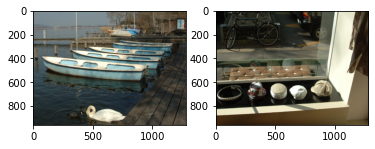

In [23]:
plt.figure()
plt.subplot(1, 2, 1)
plt.imshow(img_9)
plt.subplot(1, 2, 2)
plt.imshow(img_29)

In [24]:
np.unique(df['filenumber'])

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64.])

select fixation data corresponding to your image using the image number - that is the filenumber column

In [56]:
img_9_data = df.loc[df["filenumber"]==9].reset_index(drop=True)
img_29_data = df.loc[df["filenumber"]==29].reset_index(drop=True)

Make 2 numpy arrays, containing the mean_x and mean_y 
values of the fixations

## visualize


make a scatter plot of the fixations locations

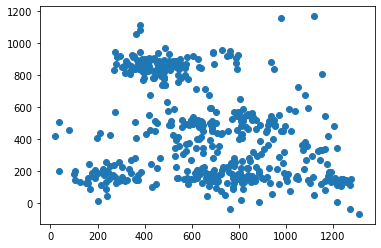

In [57]:
plt.scatter(img_9_data['mean_x'], img_9_data['mean_y'])

use a imshow and a scatter plot to show the image and the fixations together

change the color and transparency (alpha) to show the fixations



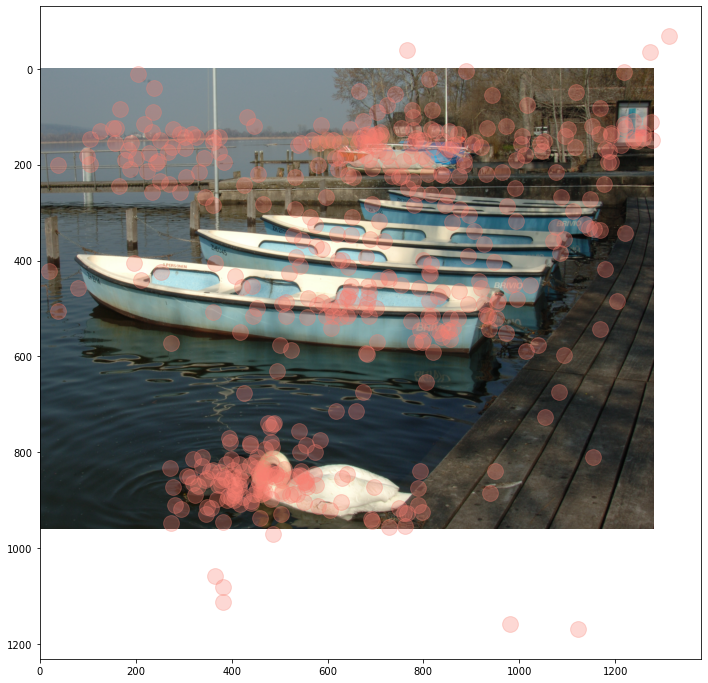

In [182]:
plt.figure(figsize=(18, 12))
plt.imshow(img_9)
plt.scatter(img_9_data['mean_x'], img_9_data['mean_y'], alpha=0.3, color="salmon", s=250);

## saliency map   - heatmap
to calcualte a saliency map, we need a matrix, same size as the image to store the number of fixations for each pixel

In [145]:
sal_map_raw = np.zeros((np.shape(img_9)[0], np.shape(img_9)[1]))
print(np.shape(sal_map_raw))

(960, 1280)


the next step is to "mark" each fixation on the above created matrix

you can think about it, as adding 1 to each pixel  for each fixation that falls there.. 



In [152]:
n_fix = len(img_9_data)
points_outside = 0

for i in range(n_fix):
    x = round(img_9_data.loc[i, "mean_x"])
    y = round(img_9_data.loc[i, "mean_y"])
    
    if (x <= np.shape(img_9)[1]) & (y <= np.shape(img_9)[0]):
        sal_map_raw[y, x] += 1
    else:
        points_outside += 1
    
print(f"finished. {points_outside} points were not included.")

finished. 7 points were not included.


visualize the result of this calculation

In [153]:
np.unique(sal_map_raw).flatten()

array([0., 1., 3.])

we can use the function from scipy, to smooth the above calculation to creat a saliency map with:

ndimage.filters.gaussian_filter()

visualize the result, on top of the image



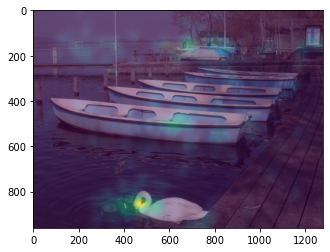

In [154]:
sal_map = ndimage.filters.gaussian_filter(sal_map_raw, sigma=20)

plt.imshow(img_9, alpha=1)
plt.imshow(sal_map, alpha=0.5)

try different values for the standard deviation and visualize the result

In [219]:
img_9_gray = np.mean(img_9, 2)

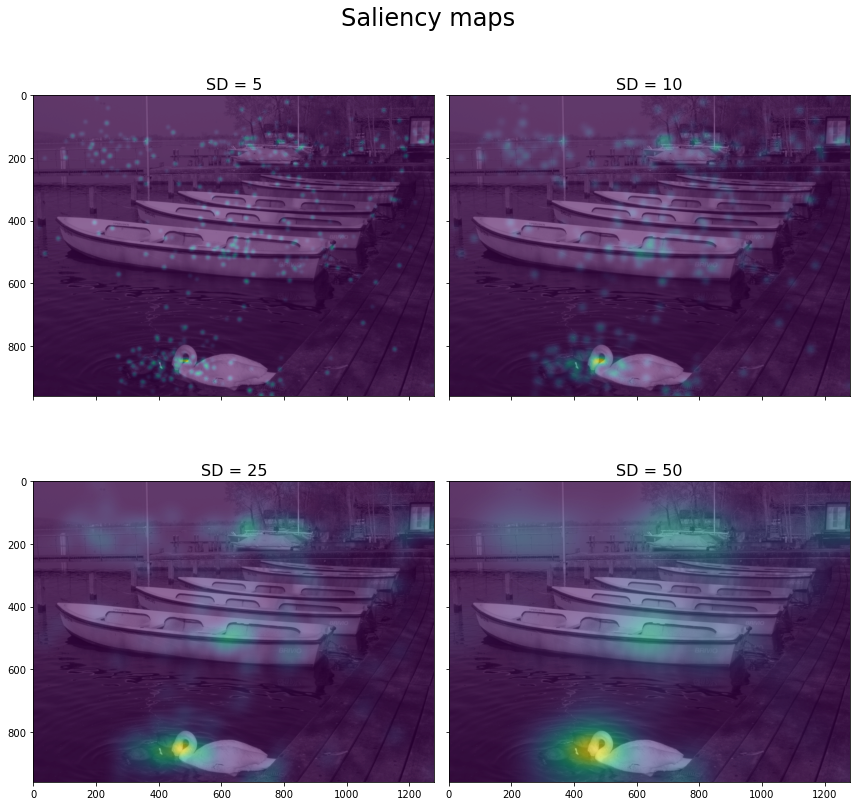

In [220]:
sds = [5, 10, 25, 50]

rows = 2
cols = 2


fig, axs = plt.subplots(cols, rows, figsize = (12, 12), sharex=True, sharey=True,)

for i in range(len(sds)):
    sal_map = ndimage.filters.gaussian_filter(sal_map_raw, sigma=sds[i])
    col = int(np.floor(i / rows))
    row = int(np.ceil(i % cols))
    if row == rows:
        break
    axs[col, row].imshow(img_9_gray, alpha=1, cmap="gray")
    axs[col, row].imshow(sal_map, alpha=0.2,)
    axs[col, row].imshow(sal_map, alpha=0.2,) # not necessary
    axs[col, row].imshow(sal_map, alpha=0.2,) # but gives
    axs[col, row].imshow(sal_map, alpha=0.2,) # a nicer contrast
    axs[col, row].set_title(f"SD = {sds[i]}", fontsize=16)

fig.suptitle("Saliency maps", fontsize=24)
fig.tight_layout()

## scanpath

visualize the overall scanpath on the image


with a line plot-- this is suprisingly easy, since the fixations are ordered by default 

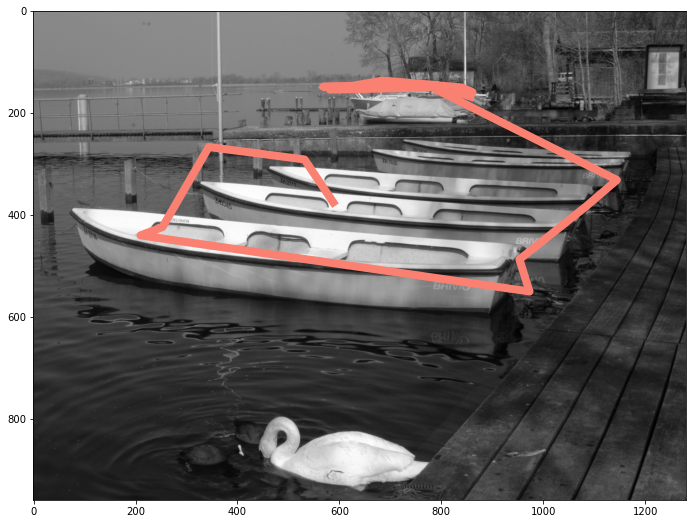

In [221]:
sbj_1 = 1

plt.figure(figsize=(12, 9))
plt.imshow(img_9_gray, cmap="gray")
plt.plot(img_9_data.loc[img_9_data["SUBJECTINDEX"] == sbj_1, "mean_x"], img_9_data.loc[img_9_data["SUBJECTINDEX"] == sbj_1, "mean_y"], color="salmon", lw=8);

what could be the caveat of the above?



visualize scanpath for 2 participants on the same figure

to select participants use = 'SUBJECTINDEX'

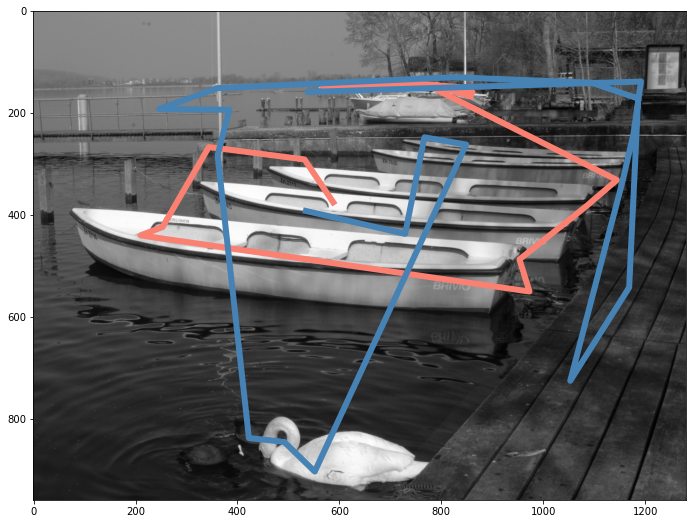

In [222]:
sbj_1 = 1
sbj_2 = 3

plt.figure(figsize=(12, 9))
plt.imshow(img_9_gray, cmap="gray")
plt.plot(img_9_data.loc[img_9_data["SUBJECTINDEX"] == sbj_1, "mean_x"], img_9_data.loc[img_9_data["SUBJECTINDEX"] == sbj_1, "mean_y"], color="salmon", lw=6)
plt.plot(img_9_data.loc[img_9_data["SUBJECTINDEX"] == sbj_2, "mean_x"], img_9_data.loc[img_9_data["SUBJECTINDEX"] == sbj_2, "mean_y"], color="steelblue", lw=6);

visualize scanpath of all participant, but with different color

how could we include direction in the scanpath visuals?

### scanpath length- saccade length

use the Pythegorian theorem, to calculate the scanpath length, for each participant, that is just the distance of subsequent fixations, added together

to calculate the saccade length, simply divide by the number of saccades 



In [ ]:
# YOUR CODE
# YOUR CODE


make a figure with 3*3 subplots
showing the scanpath of 9 different observers.

add a title for each, that shows the  number of fixation and length of the scanpath vs average length of saccades (amplitude)



In [ ]:
# YOUR CODE
# YOUR CODE